# CA5: Clustering
Ahmadreza Nopoush

id: 610301194

In [46]:
# importing libraries:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stopwords
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

## Preprocessing

we import the dataset.

In [2]:
# Load dataset
from google.colab import drive
drive.mount('/content/drive')

# Update path to your CSV file
file_path = "/content/drive/MyDrive/musicLyrics.csv"
df = pd.read_csv(file_path)

Mounted at /content/drive


In [3]:
df.head()

,Lyric
0,Cryptic psalms Amidst the howling winds A scor...
1,Im sleeping tonight with all the wolves Were d...
2,Wings of the darkest descent Fall from the rea...
3,[Verse 1] Norrid Radd was my real name Had a j...
4,Deep in the dungeons of doom and despair Sneak...


In [4]:
df.describe()

,Lyric
count,2999
unique,2999
top,[Intro] Yeah Hello Yeah there we go Lolo [Vers...
freq,1


as we can see, there are `2999` music lyrics. In order to find similiarity and clustering, we should preprocess and analyse text data.

In [5]:
df["Lyric"][0]

'Cryptic psalms Amidst the howling winds A scorching source of agonizing bliss Beneath its veil Mysteries of a life beyond Can you hear it? Sons and daughters with hearts ablaze Forsaken ones in deaths embrace Chant this hymn, behold in awe The blessed curse, abort by law Come reign with us Enslave yourself unto the beast Extend your lust Tyrants of dark supremacy Sons and daughters with hearts ablaze Forsaken ones in deaths embrace Chant this hymn, behold in awe The blessed curse, abort by law Vomiting our gospels at the trembling pillars of heaven Gods eyes wont close but endure our wrath forever Hymn of the forsaken The ashes of sanity Lies at our feet Drenched in excrements we devour it in contempt Cleansed through regurgitation ablaze We vomit forth the law of abhorrence Through blood we deny Tetragrammation Signals of death carved in flesh and bone The crystal ball has shown us our morbid fate Now lit the torch and abominate Sons and daughters with hearts ablaze Forsaken ones in 

first of all, we should make the lyrics clean; so we use `nltk` library

In [6]:
# Download required NLTK data
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [7]:
# Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [39]:
# POS tag converter
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default

def preprocess_text(text):
    #Lowercase
    text = text.lower()

    # Remove [Verse 1], [Chorus], etc.
    text = re.sub(r"\[.*?\]", "", text)

    # Remove punctuation and digits
    text = re.sub(r'[^a-z\s]', '', text)

    # Fix nonstandard endings like "workin" → "working"
    text = re.sub(r'\b(\w+?)in\b', r'\1ing', text)

    # Tokenize
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)

    # Lemmatize with correct POS and remove stopwords
    combined_stopwords = set(stopwords.words('english')).union(sklearn_stopwords)
    combined_stopwords = combined_stopwords.union({
    'im','the','with', 'of', 'in', 'on', 'a','yeah','gon','na','gonna','ayo','yo','yyo','yoyyoy','ami','id','oh','u','coz','wan','wanna','ohhhh','ohh',
    'ive', 'yea', 'ah', 'ahhhhh','ooh'})

    lemmatized = [
        lemmatizer.lemmatize(word, get_wordnet_pos(pos))
        for word, pos in tagged if word not in combined_stopwords
    ]
    lemmatized = [word for word in lemmatized if len(word) > 2]

    # Join back to string
    return ' '.join(lemmatized)

In [40]:
df['clean_lyrics'] = df['Lyric'].apply(preprocess_text)

In [41]:
df["clean_lyrics"][0]

'cryptic psalm amidst howling wind scorch source agonize bliss beneath veil mystery life hear son daughter heart ablaze forsaken one death embrace chant hymn behold awe blessed curse abort law come reign enslave unto beast extend lust tyrant dark supremacy son daughter heart ablaze forsaken one death embrace chant hymn behold awe blessed curse abort law vomit gospel tremble pillar heaven god eye wont close endure wrath forever hymn forsaken ash sanity lie foot drench excrement devour contempt cleanse regurgitation ablaze vomit forth law abhorrence blood deny tetragrammation signal death carve flesh bone crystal ball show morbid fate light torch abominate son daughter heart ablaze forsaken one death embrace chant hymn behold awe blessed curse abort law feeble abortion faith erase claw crimson dawn storm forward annihilate begone'

### Questions:

#### why we do preprocessing on text data?

The goal is to clean, normalize, and standardize text data so that it can be effectively processed by machine learning models.

| Goal                       | Preprocessing Step                 |
| -------------------------- | ---------------------------------- |
| Remove noise               | Strip punctuation, digits, headers |
| Normalize variations       | Lemmatization, stemming            |
| Reduce redundancy          | Remove stopwords                   |
| Improve clustering quality | Clean text → better embeddings     |
| Adapt to lyrics format     | Fix stylized endings (`lovin`)     |


#### What is stemming and lemmatization?

Both **stemming** and **lemmatization** are techniques used in **text preprocessing** to reduce words to a more basic form, which helps group similar words and reduce vocabulary size.

---

**Stemming:**

**Stemming** is the process of cutting off word suffixes to reduce a word to its root or base form (called the “stem”), *without regard for grammar or context*.

It often produces **non-dictionary words**.

How it works:

* Uses simple rules or heuristics.
* Does not consider part of speech (POS).
* Fast and efficient.

Example:

| Original  | Stemmed |
| --------- | ------- |
| studying  | studi   |
| worked    | work    |
| caring    | care    |
| universal | univers |

---

**Lemmatization**

Lemmatization reduces a word to its **lemma** — the *dictionary form* — **based on its part of speech** and **context**. Unlike stemming, it produces **real, meaningful words**.

How it works:

* Uses linguistic rules and dictionaries like WordNet.
* Needs POS tagging for best results.
* Slower than stemming but more accurate.

Example:

| Original | Lemmatized (as Verb) |
| -------- | -------------------- |
| studying | study                |
| worked   | work                 |
| better   | good                 |
| mice     | mouse                |

---

Key Differences

| Feature    | Stemming                   | Lemmatization               |
| ---------- | -------------------------- | --------------------------- |
| Output     | Can be non-words (`studi`) | Always real words (`study`) |
| Speed      | Fast                       | Slower                      |
| Uses POS?  | ❌ No                       | ✅ Yes                       |
| Accuracy   | Lower                      | Higher                      |
| Complexity | Simple heuristic           | Linguistically informed     |


When to Use Each

| Use Case                 | Recommendation      |
| ------------------------ | ------------------- |
| Large-scale search       | Stemming (faster)   |
| Text clustering (lyrics) | **Lemmatization** ✅ |
| Deep NLP models          | Lemmatization       |
| Real-word understanding  | Lemmatization       |

---

**In This Project We used lemmatization because**:

* It captures *real meanings* of words.
* It's important for *semantic clustering* of lyrics.
* It works better with *SentenceTransformers* (embedding models).


## Model fitting

### Extract feature Vecror

In [42]:
from sentence_transformers import SentenceTransformer

# Load the pre-trained model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Get list of cleaned lyrics
clean_lyrics = df['clean_lyrics'].tolist()

# Generate embeddings
embeddings = model.encode(clean_lyrics, show_progress_bar=True)

# Optionally store them in the DataFrame
df['embedding'] = list(embeddings)

Batches:   0%|          | 0/94 [00:00<?, ?it/s]

In [43]:
print(np.array(embeddings).shape)

(2999, 384)


### K-means

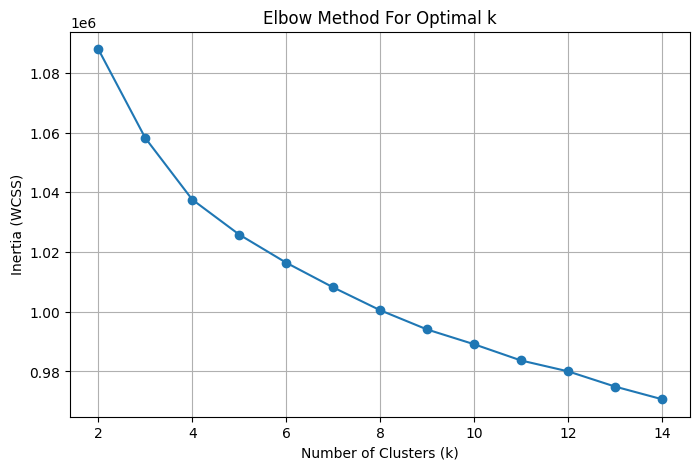

In [44]:
# Optional: scale embeddings for better KMeans performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(embeddings)

# Try different values of k
inertias = []
K_range = range(2, 15)  # you can adjust this range if needed

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.grid(True)
plt.show()

In [52]:
# Fit K-Means
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Store labels in DataFrame
df['kmeans_cluster'] = kmeans_labels

# Optional: Check counts per cluster
print(df['kmeans_cluster'].value_counts())

evaluate_clustering(X_scaled, df['kmeans_cluster'], "K-Means")

kmeans_cluster
0    1184
1     941
2     874
Name: count, dtype: int64
[K-Means] Evaluation Metrics:
  - Silhouette Score       : 0.0457 (higher is better)
  - Calinski-Harabasz Index: 132.32 (higher is better)
  - Davies-Bouldin Index   : 4.5679 (lower is better)


### DBScan

In [73]:
# Try different values — tune these based on your results
dbscan = DBSCAN(eps=0.5, min_samples=5,metric='cosine')
db_labels = dbscan.fit_predict(X_scaled)

# Save to DataFrame
df['dbscan_cluster'] = db_labels

# Count how many points in each cluster
print(df['dbscan_cluster'].value_counts())

dbscan_cluster
-1    2499
 1     375
 0      94
 2      31
Name: count, dtype: int64


### Hierarchical

In [75]:
# Try k=5 to start
hier = AgglomerativeClustering(n_clusters=3, linkage='ward',metric='euclidean')
hier_labels = hier.fit_predict(X_scaled)

# Save to DataFrame
df['hier_cluster'] = hier_labels

# Count how many points in each cluster
print(df['hier_cluster'].value_counts())

evaluate_clustering(X_scaled, df['hier_cluster'], "Hierarchical")

hier_cluster
0    1331
2     917
1     751
Name: count, dtype: int64
[Hierarchical] Evaluation Metrics:
  - Silhouette Score       : 0.0283 (higher is better)
  - Calinski-Harabasz Index: 103.35 (higher is better)
  - Davies-Bouldin Index   : 5.3942 (lower is better)


### Questions:

#### What is the defference between supervised and unsupervised learning?

1. **Supervised Learning**

Supervised learning is a type of machine learning where the model is **trained on labeled data** — each input has a known correct output or target variable.

**Goal**:
Learn a mapping from *inputs → outputs* so it can *predict labels* for new, unseen data.for Examples Classification and Regression

---

2. **Unsupervised Learning**

Unsupervised learning deals with **unlabeled data**. The model must **discover hidden patterns or structure** on its own.

There are no right answers — the algorithm finds structure by grouping, compressing, or modeling the data.

Examples:
* **Clustering:** grouping similar lyrics
* **Anomaly detection:** fraudulent transactions
* **Dimensionality reduction:** PCA, UMAP

---

Comparison Table

| Feature                | Supervised Learning            | Unsupervised Learning         |
| ---------------------- | ------------------------------ | ----------------------------- |
| 🔖 Labels Required?    | ✅ Yes                          | ❌ No                          |
| 🎯 Main Goal           | Predict known labels           | Discover structure            |
| 🧪 Examples            | Classification, Regression     | Clustering, Anomaly detection |
| 📊 Output              | Class/Value                    | Grouping, Pattern             |
| 👨‍🏫 Training Process | Trained using labeled pairs    | Learns patterns from raw data |
| ⚠️ Accuracy Check      | Easy (compare to ground truth) | Hard (no ground truth)        |

---
But since we only have lyrics without genres, we used **unsupervised learning (clustering)** to explore the hidden structure.


#### Why Do We Use Feature Vectors and What Is a Feature Vector?


**What Is a Feature Vector**?

A **feature vector** is a **numerical representation** of data — a list or array of numbers that captures the **essential information** about an object so that machine learning models can process it.

In the context of **text (like lyrics)**:

* A feature vector transforms unstructured text (words, sentences) into a structured format (numbers).
* This allows mathematical models to analyze patterns, similarities, and groupings.

---

We Use Feature Vectors Because:

1. **To Make Text Machine-Readable**

Text is **unstructured** and can’t be directly used in math.

Converting text into numbers (vectors) allows ML models like K-Means** or **DBSCAN** to measure distances, similarities, and make predictions.


2. **To Capture Semantic Meaning**

Traditional methods like Bag-of-Words or TF-IDF miss context and word order but Using models like **SentenceTransformer**, each lyric becomes a **dense vector** that Encodes **meaning and tone**


3. **For Use in Clustering Algorithms**
Clustering methods like:

* **K-Means** → uses Euclidean distance between vectors
* **DBSCAN** → uses density based on vector proximity
* **Hierarchical** → merges clusters based on vector similarity

4. **For Dimensionality Reduction & Visualization**

Techniques like **PCA**, **t-SNE**, or **UMAP** reduce high-dimensional vectors (e.g., 384D from MiniLM) to 2D or 3D for:

* Plotting
* Comparing clusters
* Exploring structure

This would be **impossible with raw text**.

---

What Makes a “Good” Feature Vector?

* **Context-aware** (e.g., distinguishes "bank of a river" from "money in a bank")
* **Compact** (e.g., 384 dimensions instead of 10,000+ in Bag-of-Words)
* **Normalized** and suitable for distance-based methods

---

Summary

| Reason                    | Explanation                           |
| ------------------------- | ------------------------------------- |
| Machines need numbers     | Vectors turn text into numeric data   |
| Captures semantic meaning | Embeddings hold word/sentence meaning |
| Enables clustering & ML   | K-Means, DBSCAN work on vectors only  |
| Helps visualization       | Reduces to 2D for PCA/UMAP/t-SNE      |


#### Explain Clustering Methods and How They Work

We used 3 popular clustering algorithms:

| Algorithm        | Type           | Key Idea                                      |
| ---------------- | -------------- | --------------------------------------------- |
| **K-Means**      | Centroid-based | Assign points to the nearest of `k` centroids |
| **DBSCAN**       | Density-based  | Find clusters as dense regions in space       |
| **Hierarchical** | Tree-based     | Merge or split clusters based on distance     |

---

**K-Means Clustering**
1. Choose number of clusters $k$.
2. Initialize $k$ random **centroids**.
3. Assign each point to the **nearest centroid**.
4. Update centroids as the **mean** of assigned points.
5. Repeat steps 3–4 until centroids stop moving (convergence).


Advantages:
* Fast and scalable
* Easy to understand and implement

Disadvantages:
* Must choose `k`
* Assumes clusters are spherical and equal-sized
* Sensitive to outliers and centroid initialization

---

**DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**
1. Choose `eps` (radius) and `min_samples` (density).
2. For each point:
   * Count how many neighbors are within radius `eps`.
   * If ≥ `min_samples`, it becomes a **core point**.
3. Connect core points and **expand clusters**.
4. Points not reachable from any cluster → labeled as **noise (-1)**.

Advantages:
* No need to choose `k`
* Handles **non-spherical** clusters
* Detects **outliers**

Disadvantages:
* Sensitive to `eps` and `min_samples`
* Doesn’t work well on very sparse data or high dimensions without tuning

---

**Hierarchical Clustering (Agglomerative)**
1. Treat each point as its own cluster.
2. At each step, **merge the closest pair** of clusters.
3. Repeat until only one cluster remains (or desired number reached).
4. You can cut the resulting **dendrogram** at any level to get `k` clusters.

Advantages:
* No need to specify exact number of clusters (can inspect dendrogram)
* Good for exploring hierarchy and structure

Disadvantages:
* Slower on large datasets
* Not robust to noise or high-dimensionality
* Sensitive to linkage method

---


| Feature          | K-Means            | DBSCAN             | Hierarchical         |
| ---------------- | ------------------ | ------------------ | -------------------- |
| Needs `k`?       | ✅ Yes              | ❌ No               | ❌ (but optional cut) |
| Handles outliers | ❌ No               | ✅ Yes              | ❌ No                 |
| Detects shape    | ❌ (spherical only) | ✅ Arbitrary shapes | ❌ (distance-based)   |
| Speed            | ✅ Fast             | ⚠️ Medium          | ❌ Slow               |
| Interpretability | ✅ Centroids        | ✅ Core points      | ✅ Tree structure     |
| Best for         | Balanced, compact  | Noisy, arbitrary   | Structural grouping  |

#### How Do Text Vectorization Methods Work? What Are Their Advantages and Disadvantages?

**What Is Text Vectorization?**

> Text vectorization is the process of converting words, sentences, or documents into **numerical vectors** so that they can be processed by machine learning algorithms.

---

**Common Text Vectorization Methods**

1. **Bag of Words (BoW)**

2. **TF-IDF (Term Frequency-Inverse Document Frequency)**

3. **Word Embeddings (Word2Vec, GloVe)**

4. **Sentence Embeddings (e.g., BERT, MiniLM)** ← *Used in this project*

---

**Bag of Words (BoW)**:

* Count the **frequency of each word** in the text.
* The vector dimension = total number of unique words (vocabu

Advantages:
* Simple and fast
* Good for short and frequent word patterns

Disadvantages:
* No context (e.g., “bank” of river vs money)
* Large sparse vectors
* Doesn’t account for importance or order of words
---

**TF-IDF**:
* Similar to BoW, but scales words by their **rarity across documents**.
* Emphasizes **important, unique terms**.
* Common words get low weight. Rare but meaningful words get high weight.

Advantages:
* Reduces impact of common words
* Highlights meaningful terms

Disadvantages:
* Still ignores word order and context
* Sparse, high-dimensional vectors
* Works poorly for small documents (like lyrics)
---

**Word Embeddings (Word2Vec, GloVe)**
* Learns a **fixed-length dense vector** for each word based on its **context**.
* Captures **semantic similarity** (e.g., king – man + woman = queen)
* `"happy"` and `"joyful"` will have similar vectors.

Advantages:
* Dense, low-dimensional vectors (e.g., 100–300D)
* Captures word meaning
* Can do arithmetic on words

Disadvantages:
* Can't represent **entire sentences** or **word order**
* One vector per word — ignores polysemy (e.g., "bank" has one vector)

---

**Sentence Embeddings (BERT, MiniLM, SentenceTransformer)**
* Uses transformer models to **encode entire sentences or texts** into **dense vectors**.
* Context-aware and captures **word meaning, order, tone**, etc.
* `"I miss you"` and `"I need you"` → similar vectors
* `"Let's dance"` and `"Start the party"` → close in space

Advantages:
* **Best quality vectors** for meaning
* Context-sensitive
* Works great for clustering and similarity

Disadvantages:
* Slower than BoW/TF-IDF
* Requires pretrained models and libraries
* Needs GPU for large-scale tasks
---
Summary Table

| Method              | Captures Meaning? | Captures Context? | Size         | Sparse? | Fast?     | Works for Sentences? |
| ------------------- | ----------------- | ----------------- | ------------ | ------- | --------- | -------------------- |
| Bag of Words        | ❌ No              | ❌ No              | Large        | ✅ Yes   | ✅ Fast    | ❌ No                 |
| TF-IDF              | ✅ Some            | ❌ No              | Large        | ✅ Yes   | ✅ Fast    | ❌ No                 |
| Word2Vec/GloVe      | ✅ Yes             | ❌ No              | Medium       | ❌ No    | ⚠️ Medium | ❌ No                 |
| SentenceTransformer | ✅ Yes             | ✅ Yes             | Small (384D) | ❌ No    | ❌ Slower  | ✅ Yes                |


#### What Are Sentence Transformers and the all-MiniLM-L6-v2 Model?

**What Is SentenceTransformer?**

**SentenceTransformers** is a Python library built on top of **Hugging Face Transformers** and **PyTorch**. It is designed to generate **semantic vector representations** (embeddings) for:
* Sentences
* Paragraphs
* Documents

>  These embeddings capture **meaning and context**, not just word frequencies.

It allows models like **BERT**, **RoBERTa**, or **MiniLM** to be fine-tuned and used directly for:

* Clustering
* Semantic search
* Text similarity
* Information retrieval
* Classification

---

**What Is `all-MiniLM-L6-v2`?**

It is one of the **pretrained models** available through SentenceTransformers.

| Property         | Value                                    |
| ---------------- | ---------------------------------------- |
| Model Name       | `all-MiniLM-L6-v2`                       |
| Architecture     | **MiniLM** (lightweight BERT)            |
| Layers           | 6 transformer layers                     |
| Dimensions       | 384                                      |
| Size             | \~80MB                                   |
| Training Tasks   | Multiple NLI + semantic similarity tasks |
| License          | MIT (free to use)                        |
| Language Support | English only                             |

**How It Works:**

* Takes an **entire sentence or lyric** as input.
* Tokenizes and passes through a transformer (MiniLM).
* Applies **mean pooling** to create a single 384-dimensional vector.

---

Advantages of `all-MiniLM-L6-v2`:

| Feature                | Benefit                                     |
| ---------------------- | ------------------------------------------- |
|  Lightweight         | Faster than BERT; ideal for real-time usage |
|  Semantic embeddings | Captures sentence meaning, tone, and nuance |
|  Fast                 | Much smaller and faster than full BERT      |
|  Low dimensionality  | 384D vectors → better for clustering & PCA  |
|  Pretrained          | No need to train from scratch               |


Disadvantages:

| Limitation               | Why It Matters                                |
| ------------------------ | --------------------------------------------- |
| Only English             | Doesn’t support multilingual input            |
| Lower accuracy than BERT | For some complex language tasks               |
| Fixed-length output      | Always returns 384D, regardless of input size |




#### What Is the Elbow Method in K-Means, and How Does It Work?

In **K-Means clustering**, you must manually choose the number of clusters $k$. But:

> **How do you know which $k$ is best?**

**elbow method** helps you determine the **optimal number of clusters** by analyzing how clustering performance changes as $k$ increases.


**Key Concept: Inertia (WCSS)**

* Inertia = **within-cluster sum of squares (WCSS)**
* It measures how **tight** the data points are within each cluster.

$$
\text{Inertia} = \sum_{i=1}^{k} \sum_{x \in C_i} \|x - \mu_i\|^2
$$

Where:
* $C_i$: cluster i
* $\mu_i$: centroid of cluster i
* $x$: each data point

> **Lower inertia is better** — it means tighter, more compact clusters.

**How the Elbow Method Works**

1. Run **K-Means** clustering for different values of $k$ (e.g., 2 to 15).
2. For each $k$, record the **inertia**.
3. Plot a **line graph**: $k$ (x-axis) vs inertia (y-axis).
4. Look for the **“elbow point”** — where the inertia **drops sharply**, then levels off.

**How to Choose $k$**

* **Look for the "elbow"** in the curve — where inertia decreases sharply, then starts to flatten.
* That point is the best **trade-off** between:
  * Model complexity (more clusters)
  * Clustering quality (lower inertia)

## PCA, Evaluation

### Questions:

#### What Is PCA and How Does It Work?

> **PCA** stands for **Principal Component Analysis**.
PCA **transforms** the original data into a new coordinate system where:
* The **first axis (PC1)** captures the most variance
* The **second axis (PC2)** captures the second most
* And so on…

You can then **ignore the less important axes** (components) and keep only the top `k`.

**usage:**

| Reason                   | Explanation                                |
| ------------------------ | ------------------------------------------ |
| Dimensionality reduction | Reduces vector size (e.g., 384D → 2D/3D)   |
| Visualization            | Allows plotting data in 2D or 3D           |
| Noise reduction          | Removes small, irrelevant variations       |
| Speeds up clustering     | Smaller dimensions = faster distance calcs |
| Avoids overfitting       | Less noise → simpler models                |

---

**How PCA Works**

Assume your data has many features (e.g., 384-dimensional embeddings).

**Step 1: Standardize the Data**

* Subtract the **mean** of each feature (center the data).
* Optionally divide by standard deviation (scale).

**Step 2: Compute the Covariance Matrix**

* Shows how features vary **with respect to each other**.
* Helps understand how data is **spread or correlated**.

$$
\text{Cov}(X) = \frac{1}{n-1}(X - \bar{X})^T (X - \bar{X})
$$

**Step 3: Compute Eigenvalues and Eigenvectors**

* **Eigenvectors** = new axes (principal components)
* **Eigenvalues** = importance (variance explained)

**Step 4: Sort and Select Top `k` Components**

* Keep the top 2 or 3 components(“Give me just the top 2 components, the 2 best directions that summarize the structure of this high-dimensional data.”)
* These are the directions that preserve most information

**Step 5: Transform the Original Data**

* Project the original data onto the selected component



#### What Are Clustering Evaluation Metrics (e.g., Silhouette Score, Homogeneity Score), and How Are They Calculated?

Clustering is **unsupervised**, so we often need **evaluation metrics** to judge how good our clusters are — both **with and without ground truth** labels.

There are two main types:

| Type                               | Example Metrics                                       |
| ---------------------------------- | ----------------------------------------------------- |
| **Internal metrics** (no labels)   | ✅ Silhouette Score, Calinski-Harabasz, Davies-Bouldin |
| **External metrics** (need labels) | ✅ Homogeneity, Completeness, Adjusted Rand Index      |

---

**Silhouette Score** (Internal)

*It Measures*:

* How **similar** a point is to its **own cluster** vs. other clusters.
* Combines **intra-cluster cohesion** and **inter-cluster separation**.

*Formula (for one point $i$)*:

Let:

* $a(i)$ = average distance to points **in the same cluster**
* $b(i)$ = average distance to points **in the nearest neighboring cluster**

Then:

$$
\text{Silhouette}(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$$

* Range: **-1 to 1**

  * `1`: well-clustered
  * `0`: on the border
  * `< 0`: possibly misclassified
---
**Homogeneity Score** (External)

It Measures:
* Measures if **each cluster contains only members of a single class**.
> Good for comparing clusters to **true labels** (if available).

*Formula*:

$$
\text{Homogeneity} = 1 - \frac{H(C|K)}{H(C)}
$$

Where:

* $H(C|K)$: conditional entropy of classes given clusters

* $H(C)$: entropy of the class distribution

* Range: **0 to 1**

  * `1`: perfectly homogeneous (pure clusters)
  * `0`: completely random grouping

---

**Completeness Score** (External)

It Measures:
* Are **all members of a class assigned to the same cluster**?
* The reverse of homogeneity.



**V-Measure Score** (External)

* Harmonic mean of **homogeneity** and **completeness**:

$$
\text{V} = 2 \cdot \frac{(homogeneity \cdot completeness)}{(homogeneity + completeness)}
$$

* Range: 0 to 1

---

**Calinski-Harabasz Index** (Internal)

It Measures:

* Ratio of **between-cluster variance** to **within-cluster variance**

$$
\text{Score} = \frac{\text{tr}(B_k)}{\text{tr}(W_k)} \cdot \frac{n - k}{k - 1}
$$

* Higher score = better-defined clusters


**Davies-Bouldin Index** (Internal)

It Measures:
* **Average similarity** between clusters
* Based on intra-cluster and inter-cluster distances
* Lower score = better clustering

---

**Summary Table**

| Metric                  | Labels Required? | Good Value       | Measures                              |
| ----------------------- | ---------------- | ---------------- | ------------------------------------- |
| **Silhouette Score**    | ❌ No             | Close to 1       | Cohesion vs. Separation               |
| **Homogeneity**         | ✅ Yes            | Close to 1       | Purity of clusters                    |
| **Completeness**        | ✅ Yes            | Close to 1       | Each class in one cluster             |
| **V-Measure**           | ✅ Yes            | Close to 1       | Balance of Homogeneity & Completeness |
| **Adjusted Rand Index** | ✅ Yes            | Close to 1       | Label agreement                       |
| **Calinski-Harabasz**   | ❌ No             | Higher is better | Cluster separation vs compactness     |
| **Davies-Bouldin**      | ❌ No             | Lower is better  | Cluster similarity                    |



### PCA

In [76]:
# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Save PCA result to DataFrame
df['pca_1'] = X_pca[:, 0]
df['pca_2'] = X_pca[:, 1]

print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.07428567 0.04347537]


this function plot the clusters in 2D

In [77]:
def plot_clusters(labels, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x='pca_1', y='pca_2',
        hue=labels,
        data=df,
        palette='tab10',
        legend='full',
        s=50
    )
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

### Evaluation

In [47]:
# Define function to evaluate a clustering
def evaluate_clustering(X, labels, name):
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    if n_clusters <= 1:
        print(f"[{name}] Not enough clusters to evaluate (only {n_clusters} cluster).")
        return

    sil_score = silhouette_score(X, labels)
    calinski_score = calinski_harabasz_score(X, labels)
    davies_score = davies_bouldin_score(X, labels)

    print(f"[{name}] Evaluation Metrics:")
    print(f"  - Silhouette Score       : {sil_score:.4f} (higher is better)")
    print(f"  - Calinski-Harabasz Index: {calinski_score:.2f} (higher is better)")
    print(f"  - Davies-Bouldin Index   : {davies_score:.4f} (lower is better)")

## Results:

#### PCA & Score of K-Means

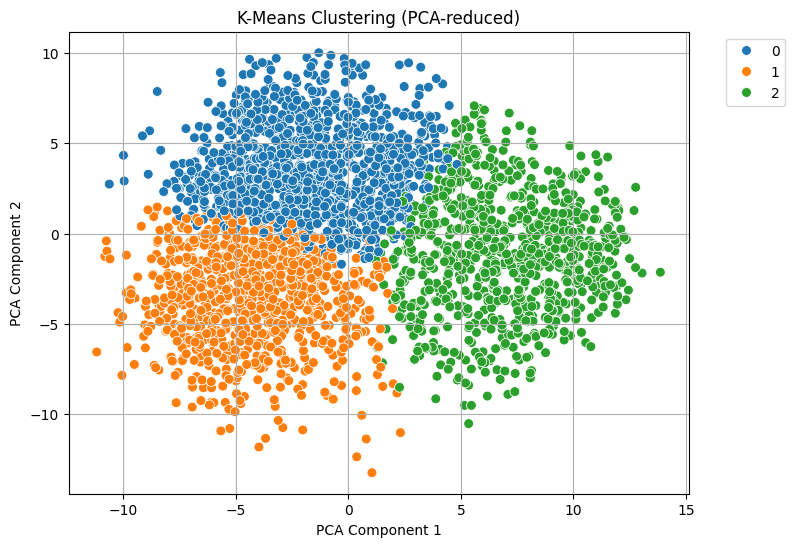

[K-Means] Evaluation Metrics:
  - Silhouette Score       : 0.0457 (higher is better)
  - Calinski-Harabasz Index: 132.32 (higher is better)
  - Davies-Bouldin Index   : 4.5679 (lower is better)


In [78]:
# K-Means PCA
plot_clusters(df['kmeans_cluster'], 'K-Means Clustering (PCA-reduced)')

evaluate_clustering(X_scaled, df['kmeans_cluster'], "K-Means")

#### PCA & Score of DBSCAN

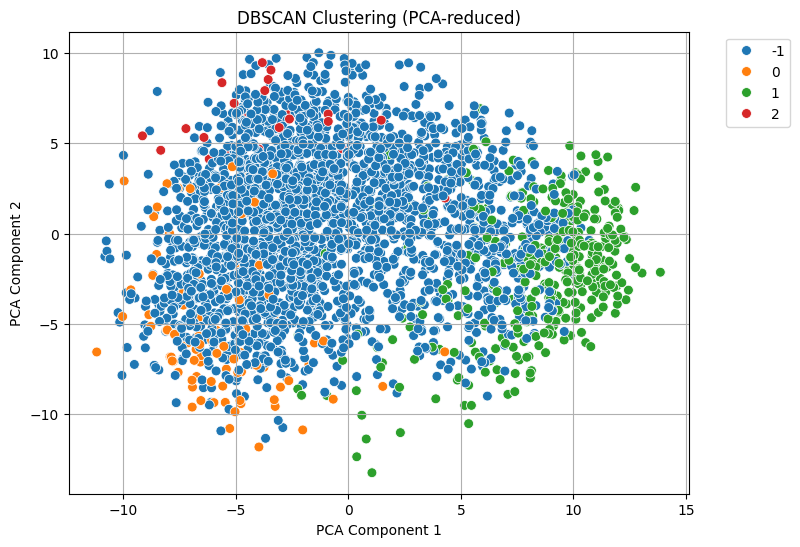

[DBSCAN] Evaluation Metrics:
  - Silhouette Score       : -0.0304 (higher is better)
  - Calinski-Harabasz Index: 41.05 (higher is better)
  - Davies-Bouldin Index   : 3.6952 (lower is better)


In [79]:
# DBSCAN PCA
plot_clusters(df['dbscan_cluster'], 'DBSCAN Clustering (PCA-reduced)')

evaluate_clustering(X_scaled, df['dbscan_cluster'], "DBSCAN")

#### PCA & Score of Hierarchical

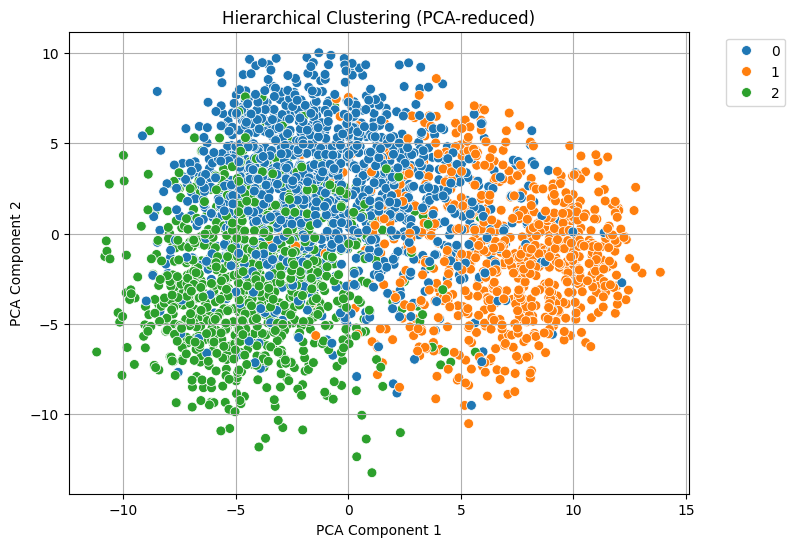

[Hierarchical] Evaluation Metrics:
  - Silhouette Score       : 0.0283 (higher is better)
  - Calinski-Harabasz Index: 103.35 (higher is better)
  - Davies-Bouldin Index   : 5.3942 (lower is better)


In [80]:
# Hierarchical PCA
plot_clusters(df['hier_cluster'], 'Hierarchical Clustering (PCA-reduced)')

evaluate_clustering(X_scaled, df['hier_cluster'], "Hierarchical")

### Compare two Samples

In [81]:
def print_sample_lyrics_from_clusters(df, cluster_col, text_col='Lyric', n_samples=3):
    num_clusters = df[cluster_col].nunique()
    for cluster in range(num_clusters):
        print(f"\n--- Cluster {cluster} ---")
        sample = df[df[cluster_col] == cluster].sample(n=min(n_samples, len(df[df[cluster_col] == cluster])), random_state=42)
        for i, lyric in enumerate(sample[text_col]):
            print(f"\nSample {i+1}:\n{lyric}")

## Conclusion

as we can see k-means gives better result than other methodes, its evaluation scores are better than others.

Now we compare 2 sample of each cluster to see the similarity...

**We have prior information from TA that these lyrics are chosen from 3 music genres: POP, ROCK, RAP**

In [82]:
print_sample_lyrics_from_clusters(df, cluster_col='kmeans_cluster', n_samples=2)


--- Cluster 0 ---

Sample 1:
The blood is my foe A bet of my own I noticed Im impaired ? The blood is rushing down The blood is rushing down Im in ? I noticed in the air Your words are true but fair I know this It got me bad The blood is rushing down The blood is rushing down Im in Keep the valley? broken Keep the valley broken Keep the valley broken Keep the valley broken The blood is my foe A bet of my own I know this, it got me bad The blood is rushing down The blood is rushing down Im in I noticed in the air Your words are true but fair I know this It got me bad The blood is rushing down The blood is rushing down Im in Keep the valley broken Keep the valley broken Keep the valley broken Keep the valley broken The blood is my foe A bet of my own I know this, it got me bad The blood is rushing down The blood is rushing down Im in

Sample 2:
Ronnie dont fall 3 times Ronnie dont fall in love with me We grew together, I knew you when We were so inseparable And everything we did was the

Among the clusters formed, we sampled lyrics from each and searched the web to identify the songs and infer genres:

Cluster 0 grouped emotional, introspective songs. One example was "Ronnie Don’t Fall" by Andru Donalds, an R&B/Soul song.

Cluster 1 consisted of dark, intense, and abstract lyrics, likely from metal or rock.

Cluster 2 captured motivational and uplifting lyrics, with “Keep Your Head to the Sky” by Blaque (featuring Left Eye), which falls into the R&B/Pop genre.

These results indicate that the clustering successfully grouped lyrics with similar tone, emotion, and meaning — even without genre labels — demonstrating the effectiveness of sentence embeddings + unsupervised clustering for lyrical content analysis